# Second model
- Implement some new pipeline functionality. 
- Refactor pre-processing and pipeline code into '../lib'

# TODO - 
- implement a higher power model (https://www.kaggle.com/mineshjethva/exploratory-data-analysis-lightgbm)
- more complex pipeline components. Good example of parallel FeatureUnion
http://scikit-learn.org/stable/auto_examples/hetero_feature_union.html#sphx-glr-auto-examples-hetero-feature-union-py

## Features to engineer
- PCA or other dimensionality reduction on all the housing material features

In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [20]:
import lightgbm as lgb

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [4]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from lib.preprocessing import preprocess
from lib.pipeline import f1_scorer, FeatureExtractor

In [5]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

## Important: 
According to the competition (https://www.kaggle.com/c/costa-rican-household-poverty-prediction/discussion/61403), **ONLY heads of household are used in the scoring**. So we should only fit and evaluate our model on these observations (though in preprocessing we may use all individuals in household-level feature engineering). 
We do, however, need to keep all test data observations for submission. (here is a kernel showing some exploration of discrepancy of labels within households and some individuals without a head of household, but should be irrelevant if we only train on heads https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough)

In [92]:
X_train = preprocess(train).drop('Target', axis = 1).query('parentesco1 == 1') #try subsetting to ONLY train on head of household
X_test = preprocess(test)
y_train = train.query('parentesco1 == 1')['Target'] #try subsetting to ONLY train on head of household

In [107]:
test_features = ['meaneduc', 'no_primary_education', 'hh_max_rez_esc_scaled'] + [
    'wall_quality', 'roof_quality', 'floor_quality', 'house_material_vulnerability'] + [
    'house_utility_vulnerability', 'sanitario1', 'pisonotiene', 'cielorazo', 'abastaguano', 'noelec', 'sanitario1'] + [
    'asset_index', 'v18q', 'v18q1', 'refrig', 'computer', 'television'] + [
    'tamviv', 'hogar_nin', 'overcrowding'] + [
    'calc_dependency', 'calc_dependency_bin'] + [
    'phones_pc', 'tablets_pc', 'rooms_pc', 'rent_pc'] + [
    'v2a1', 'v2a1_missing']

X_train[test_features].head()

,meaneduc,no_primary_education,hh_max_rez_esc_scaled,wall_quality,roof_quality,floor_quality,house_material_vulnerability,house_utility_vulnerability,sanitario1,pisonotiene,...,hogar_nin,overcrowding,calc_dependency,calc_dependency_bin,phones_pc,tablets_pc,rooms_pc,rent_pc,v2a1,v2a1_missing
0,10.0,0,NaN,1,0,0,2,0,0,0,...,0,1.000000,0.0,0,1.00,0.00,3.00,190000.0,190000.0,0
1,12.0,0,NaN,1,1,1,0,0,0,0,...,0,1.000000,1.0,1,1.00,1.00,4.00,135000.0,135000.0,0
2,11.0,0,NaN,1,2,2,0,0,0,0,...,0,0.500000,1.0,1,0.00,0.00,8.00,0.0,0.0,0
5,11.0,0,0.090909,2,2,2,0,0,0,0,...,2,1.333333,1.0,1,0.75,0.25,1.25,45000.0,180000.0,0
8,10.0,0,0.200000,0,0,1,2,0,0,0,...,2,4.000000,1.0,1,0.25,0.00,0.50,32500.0,130000.0,0


In [108]:
model = Pipeline(steps=[('feature_extraction', FeatureExtractor(test_features)),
                        ('imputer', Imputer(strategy = 'mean')),
                ('random_forest', RandomForestClassifier(random_state = 1))])

kfold = StratifiedKFold(n_splits=5, random_state=1)

In [109]:
DEPTHS = list(range(10,20))
param_grid = dict(random_forest__max_depth=DEPTHS)
grid = GridSearchCV(model, param_grid=param_grid, cv=kfold, scoring=f1_scorer)
grid.fit(X_train, y_train)

# print(grid.cv_results_['mean_test_score'])

best_params = grid.best_params_
print(best_params)

{'random_forest__max_depth': 15}


In [110]:
# clf = lgb.LGBMClassifier(max_depth=-1, learning_rate=0.1, objective='multiclass',
#                              random_state=None, silent=True, metric='None', 
#                              n_jobs=4, n_estimators=5000, class_weight='balanced',
#                              colsample_bytree =  0.89, min_child_samples = 30, num_leaves = 32, subsample = 0.96)

In [111]:
DEPTH = best_params['random_forest__max_depth']

model = Pipeline(steps=[('feature_extraction', FeatureExtractor(test_features)),
                        ('imputer', Imputer(strategy = 'mean')),
                ('random_forest', RandomForestClassifier(random_state=1, max_depth=DEPTH))])
                # ('lgb', clf)])
model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('feature_extraction', FeatureExtractor(cols=['meaneduc', 'no_primary_education', 'hh_max_rez_esc_scaled', 'wall_quality', 'roof_quality', 'floor_quality', 'house_material_vulnerability', 'house_utility_vulnerability', 'sanitario1', 'pisonotiene', 'cielorazo', 'abastaguano', 'noelec', 'sanita...estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False))])

In [112]:
%%time
cv_score = cross_val_score(model, X_train, y_train, cv = kfold, scoring = f1_scorer)
print(cv_score.mean())
print(f'5 Fold Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

0.35391263771046966
5 Fold Cross Validation F1 Score = 0.3539 with std = 0.0132
Wall time: 206 ms


In [113]:
estimator = model.steps[-1][1]
feature_importances = pd.DataFrame({'feature': test_features, 'importance': estimator.feature_importances_})
feature_importances.sort_values('importance', ascending=False)

,feature,importance
0,meaneduc,0.140700
27,rooms_pc,0.084665
25,phones_pc,0.082968
23,calc_dependency,0.078438
22,overcrowding,0.071395
21,hogar_nin,0.043699
20,tamviv,0.042016
2,hh_max_rez_esc_scaled,0.041432
28,rent_pc,0.041331
29,v2a1,0.039231


# Submission

In [39]:
y_pred = model.predict(X_test)

(array([ 1467.,     0.,     0.,  3671.,     0.,     0.,  1867.,     0.,
            0., 16851.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

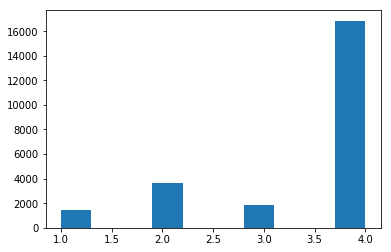

In [40]:
plt.hist(y_pred)

In [15]:
y_pred_series = pd.Series(y_pred, name = 'Target')
submission = pd.concat([X_test['Id'], y_pred_series], axis=1)

In [16]:
submission.to_csv('../submission.csv', index=None)

In [17]:
submission.head()

,Id,Target
0,ID_2f6873615,4
1,ID_1c78846d2,4
2,ID_e5442cf6a,4
3,ID_a8db26a79,4
4,ID_a62966799,4
